# Getting Started

In [1]:
import qexpy as q

The core of QExPy is a data structure called ```ExperimentalValue```, which represents a value with an uncertainty. Any measurements recorded with QExPy and the result of any data analysis done with these measurements will all be wrapped in an instance of this class.

In [2]:
# a measurement can be taken with a value, an uncertainty, a unit and a name 
# (the last two are optional)
m = q.Measurement(15, 0.5, unit="kg", name="mass")
print(m)

mass = 15.00 +/- 0.50 [kg]


In [3]:
# multiple measurements can be taken towards the same quantity
t = q.Measurement([5, 4.9, 5.3, 4.7, 4.8, 5.3], unit="s", name="time")

# this measurement will contain some basic statistic properties
print("Mean: {}".format(t.mean))
print("Error on the mean: {}".format(t.error_on_mean))
print("Standard deviation: {}".format(t.std))

Mean: 5.0
Error on the mean: 0.10327955589886441
Standard deviation: 0.2529822128134702


In [4]:
# by default, the mean and error on the mean are used for this measurement
print(t)

time = 5.00 +/- 0.10 [s]


In [5]:
# however, you can change that if you want
t.use_std_for_uncertainty()
print(t)

time = 5.00 +/- 0.25 [s]


In [6]:
# let's do some calculations with measurements
vi = q.Measurement(0, unit="m/s", name="initial speed")
vf = q.Measurement(10, 0.5, unit="m/s", name="final speed")
a = (vf - vi) / t  # acceleration
a.name = "acceleration"
print(a)

acceleration = 2.00 +/- 0.14 [m⋅s^-2]


In [7]:
f = m * a
f.name = "force"
# as you can see below, the errors as well as units are propagated properly.
print(f)

force = 30.0 +/- 2.4 [kg⋅m⋅s^-2]


## Methods of Error Propagation

There are two error methods supported by QExPy.

#### Derivative Method (default)

By default, QExPy propagates the uncertainties using the "derivative" method. That is, for a function, $f(x,y)$, that depends on measured quantities $x\pm\sigma_x$ and $y\pm\sigma_y$, with covariance $\sigma_{xy}$ between the two measured quantities, the uncertainty in $f$ is given by:

$$ \sigma_f = \sqrt{ \left(\frac{\partial f}{\partial x} \sigma_x \right)^2 + \left(\frac{\partial f}{\partial y} \sigma_y \right)^2 + 2 \frac{\partial f}{\partial x} \frac{\partial f}{\partial y}\sigma_{xy} }$$

Although the derivative method is commonly taught in undergraduate laboratories, it is only valid when the relative uncertainties in the quantities being propagated are small (e.g. less than ~10% relative uncertainty). This method is thus not strongly encouraged, although it has been made the default because it is so prevalent in undergraduate teaching.

#### Monte Carlo Method (recommanded)

The MC method is based on a statiscal understanding of the measurements. In the QExPy implementation, currently, the main assumptions is that the uncertainty in a quantity is given by a "standard error"; that is, if $x = 10\pm 1$, then we *assume* that this error and uncertainty should be interpreted as: "if we measure $x$ multiple times, we will obtain a set of measurements that are normally distributed with a mean of 10 and a standard deviation of 1". In other words, we assume that $x$ has a 68% chance of being in the range between 9 and 11.

The MC method then uses the assumption that measured quantities are normally distributed and use this to propagate the errors by using Monte Carlo simulation. Suppose that we have measured $x$ and $y$ and wish to determine the central value and uncertainty in $x=x+y$. The Monte Carlo method will generate normally distributed random values for $x$ and $y$ (the random numbers will be correctly correlated if the user has indicated that $x$ and $y$ are correlated), then it will add those random values together, to obtain a set of values for $z$. The mean and standard deviation of the random values for $z$ are taken as the central value and uncertainty in $z$. 

force = 30.08 +/- 2.37 [kg⋅m⋅s^-2]


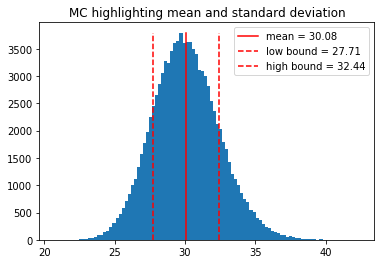

In [8]:
# first change the number of significant figures so that we can see the difference
q.set_sig_figs_for_error(3)

# you can change the error method
q.set_error_method(q.ErrorMethod.MONTE_CARLO)
print(f)

# you can see the histogram of samples from the Monte Carlo simulation
f.mc.show_histogram()

In the above example, the result of a Monte Carlo simulation has a perfect Gaussian distribution. However, this might not always be the case.

0.848 +/- 0.435


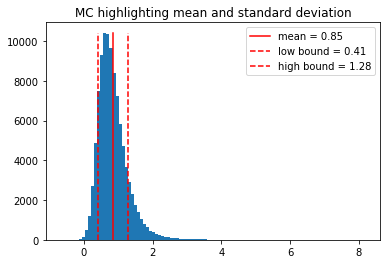

In [9]:
# let's try calculating the gravitational force between two stars

G = 6.67384e-11  # the gravitational constant
m1 = q.Measurement(40e4, 2e4, name="m1", unit="kg")
m2 = q.Measurement(30e4, 10e4, name="m2", unit="kg")
r = q.Measurement(3.2, 0.5, name="distance", unit="m")

f = G * m1 * m2 / (r ** 2)
print(f)

f.mc.show_histogram()

As you can see, in this case, the mean and standard deviation of the distribution doesn't quite capture the center value and uncertainty we are looking for. We can try a different strategy where we find the mode (most probably value) of the distribution, and a confidence range.

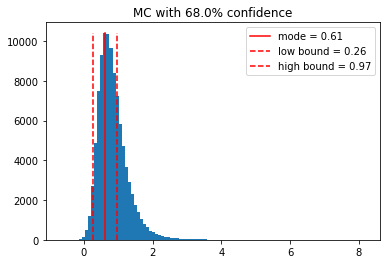

0.613 +/- 0.354


In [10]:
# change the mc strategy
f.mc.use_mode_with_confidence()

# show the histogram again
f.mc.show_histogram()

# also print the value
print(f)

By default, the confidence level is 68%, but we can change that.

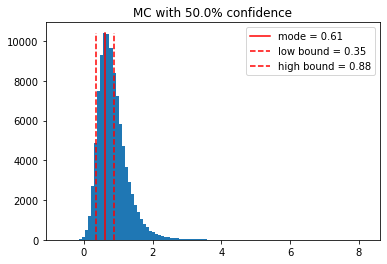

0.613 +/- 0.354


In [11]:
# change the confidence
f.mc.confidence = 0.5

# show the histogram again
f.mc.show_histogram()

# also print the value
print(f)

As you can see, most of the samples are concentrated in the first half of the histogram. In order to increase resolution, the user can manually set the range of the histogram to focus on the region with the most samples.

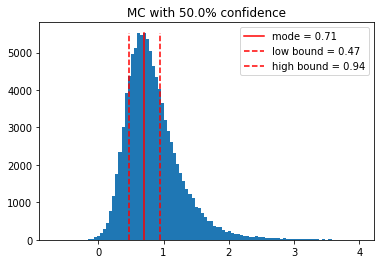

In [12]:
# try show histogram again
f.mc.show_histogram(range=(-1,4))

If you feel like this subset of the distribution is somewhat more representative of the quantity, you can set the range for Monte Carlo simulation to this interval

0.845 +/- 0.422


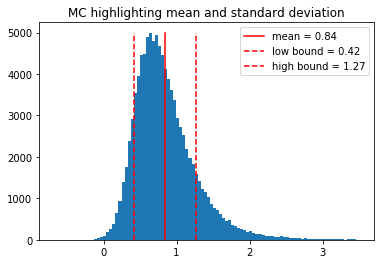

In [13]:
# try setting the range
f.mc.set_xrange(-1, 3.5)
f.mc.use_mean_and_std()  # let's see what the mean and std is now
print(f)
f.mc.show_histogram()

## Print Style and Formatting

In [14]:
# you can specify the precision of the values
q.set_sig_figs_for_value(3)
print("{} (the value has 3 significant figures)".format(f))
q.set_sig_figs_for_error(3)
print("{} (the uncertainty has 3 significant figures)".format(f))

0.845 +/- 0.422 (the value has 3 significant figures)
0.845 +/- 0.422 (the uncertainty has 3 significant figures)


In [15]:
# you can change the print formatting
q.set_print_style(q.PrintStyle.SCIENTIFIC)
print(f)
q.set_print_style(q.PrintStyle.LATEX)
print(f)
# or reset it to default
q.set_print_style(q.PrintStyle.DEFAULT)
print(f)

(8.45 +/- 4.22) * 10^-1
(8.45 \pm 4.22) * 10^-1
0.845 +/- 0.422


In [16]:
# you can change the style of how units are displayed
q.set_unit_style(q.UnitStyle.EXPONENTS)  # this is the default
print("default (exponent) style unit printing: {}".format(f.unit))
q.set_unit_style(q.UnitStyle.FRACTION)  # more intuitive but sometimes ambiguous
print("fraction style unit printing: {}".format(f.unit))

# print the complete value
print("\nThe complete value representation will change accordingly:\n{}".format(f))

default (exponent) style unit printing: 
fraction style unit printing: 

The complete value representation will change accordingly:
0.845 +/- 0.422


## Correlated Measurements

Sometimes when two series of measurements are correlated, the error propagation should reflect that. It's worth noting that repeated measurements of the same length are not automatically correlated. Whether two measurements are physically correlated is at the discretion of the user. There are two values related to correlated measurements. The "covariance" indicates the extent to which two random variables change in tandem, and "correlation" is indicates how strongly two variables are related, which is confined between -1 and 1

In [17]:
q.reset_default_configuration()  # first reset everything to default
q.set_sig_figs_for_error(3)

# first let's take two series of measurements
m1 = q.Measurement([20, 20.2, 20.3, 20.4])
m2 = q.Measurement([20, 20.1, 19.8, 20.3])

result = m1 + m2
print(result)

40.275 +/- 0.135


In [18]:
# let's say m1 and m2 are measured together, and they might be correlated
q.set_correlation(m1, m2)  # this declares the correlation

# since m1 and m2 are of the same length, QExPy is able to calculate the covariance
cor = q.get_correlation(m1, m2)
cov = q.get_covariance(m1, m2)
print("Covariance: {}\nCorrelation: {}".format(cov, cor))

Covariance: 0.011666666666666523
Correlation: 0.3281650616569432


In [19]:
# as a result, the error will be recalculated
result.recalculate()  # since something changed, this ensures that everything is updated
print(result)

40.275 +/- 0.155


In [20]:
# the monte carlo simulated results will also be properly correlated
result.recalculate()
q.set_error_method(q.ErrorMethod.MONTE_CARLO)
print(result)

40.274 +/- 0.154


In [21]:
# the user can personally set the correlation between two values
q.set_correlation(m1, m2, 0.8)
# q.set_covariance(m1, m2, 0.02)

result.recalculate()  # first ask that the value is updated

q.set_error_method(q.ErrorMethod.DERIVATIVE)
print(result)
q.set_error_method(q.ErrorMethod.MONTE_CARLO)
print(result)

40.275 +/- 0.180
40.277 +/- 0.181


## Measurement Arrays

QExPy can also handle a series of measurements with ```MeasurementArray```, which is an array of individual measurements, each with an uncertainty. This is a sub-class of ```numpy.ndarray```, so it can be operated on as one.

In [22]:
q.reset_default_configuration()
q.set_sig_figs_for_error(2)

# you can record an array with the same uncertainty throughout
arr1 = q.MeasurementArray([1, 2, 3, 4, 5], 0.5, name="length", unit="m")
print(arr1)

length = [ 1.00 +/- 0.50, 2.00 +/- 0.50, 3.00 +/- 0.50, 4.00 +/- 0.50, 5.00 +/- 0.50 ] (m)


In [23]:
# if the error is left out, it's by default set to 0
arr2 = q.MeasurementArray([1, 2, 3, 4, 5])
print(arr2)

[ 1.0 +/- 0, 2.0 +/- 0, 3.0 +/- 0, 4.0 +/- 0, 5.0 +/- 0 ]


In [24]:
# you can record an array of measurement with distinct uncertainties
arr3 = q.MeasurementArray(
    [1, 2, 3, 4, 5], [0.1, 0.2, 0.3, 0.4, 0.5], name="length", unit="m")
print(arr3)

length = [ 1.00 +/- 0.10, 2.00 +/- 0.20, 3.00 +/- 0.30, 4.00 +/- 0.40, 5.00 +/- 0.50 ] (m)


In [25]:
# individual measurements can be extracted
measurement = arr3[2]
print(measurement)

length_2 = 3.00 +/- 0.30 [m]


In [26]:
# the measurement array has basic statistical uncertainties
print("Mean: {}".format(arr3.mean()))
print("Sum: {}".format(arr3.sum()))
print("Standard Deviation: {}".format(arr3.std()))
print("Error Weighted Mean: {}".format(arr3.error_weighted_mean()))

Mean: mean of length = 3.00 +/- 0.71 [m]
Sum: length = 15.00 +/- 0.74 [m]
Standard Deviation: 1.5811388300841898
Error Weighted Mean: 1.5600683241601823


In [27]:
# basic operations with measurement arrays
arr4 = arr3.delete(0)
arr4.name = "arr4"
print(arr4)
arr5 = arr4.append((6, 0.6))
arr5.name = "arr5"
print(arr5)
# operations can be chained
arr6 = arr4.delete(0).append([(6, 0.6),(7, 0.7)])
arr6.name = "arr6"
print(arr6)
arr7 = arr4.insert(0, (6, 0.6))
arr7.name = "arr7"
print(arr7)

arr4 = [ 2.00 +/- 0.20, 3.00 +/- 0.30, 4.00 +/- 0.40, 5.00 +/- 0.50 ] (m)
arr5 = [ 2.00 +/- 0.20, 3.00 +/- 0.30, 4.00 +/- 0.40, 5.00 +/- 0.50, 6.00 +/- 0.60 ] (m)
arr6 = [ 3.00 +/- 0.30, 4.00 +/- 0.40, 5.00 +/- 0.50, 6.00 +/- 0.60, 7.00 +/- 0.70 ] (m)
arr7 = [ 6.00 +/- 0.60, 2.00 +/- 0.20, 3.00 +/- 0.30, 4.00 +/- 0.40, 5.00 +/- 0.50 ] (m)


In [28]:
# the index of variables are calculated accordingly
for element in arr7:
    print(element)

arr7_0 = 6.00 +/- 0.60 [m]
arr7_1 = 2.00 +/- 0.20 [m]
arr7_2 = 3.00 +/- 0.30 [m]
arr7_3 = 4.00 +/- 0.40 [m]
arr7_4 = 5.00 +/- 0.50 [m]


## Math Functions

QExPy includes wrappers for some basic math functions, which works on both individual values and measurement arrays. Available functions include basic trig functions such as ```sin```, ```cos```, ```tan```, and ```sec```, ```csc```, and other functions such as ```sqrt```, ```log```, ```exp```.

In [29]:
# for example, try finding out the time it takes for an object to fall 8 meters
h = q.Measurement(8,0.1)
g = 9.81
t = q.sqrt(2*h/g)
t.name = "time"
t.unit = "s"
print(t)

time = 1.2771 +/- 0.0080 [s]


In [30]:
# the log function can take 1 or 2 arguments
res = q.log(h)  # by default the base is e
print("log base e of h: {}".format(res))
res = q.log(2, h)  # you can specify the base
print("log base 2 of h: {}".format(res))

log base e of h: 2.079 +/- 0.012
log base 2 of h: 3.000 +/- 0.018


Right now unit propagation with functions is not yet supported. It will be implemented in future versions